In [1]:
import numpy as np
import pandas as pd
import pystan as ps
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
#fetching data into table
import geopandas as gpd

My_file_path_name = r'C:\Users\himab\Documents\RiverSimilarity\data\HydroRIVERS_v10_na_shp\HydroRIVERS_v10_na_shp\HydroRIVERS_v10_na.dbf'

table = gpd.read_file(My_file_path_name)

ERROR:fiona._env:Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.


In [3]:
table.rename(columns = {'LENGTH_KM':'l', 'UPLAND_SKM':'A', 'DIS_AV_CMS':'Q', 'ORD_STRA':'n'}, inplace = True)
table = table[['l','A','Q','n']]
table.head()

,l,A,Q,n
0,1.72,13.9,0.121,1
1,3.38,24.7,0.196,1
2,1.94,13.7,0.160,1
3,1.12,10.3,0.116,1
4,5.95,20.7,0.242,1


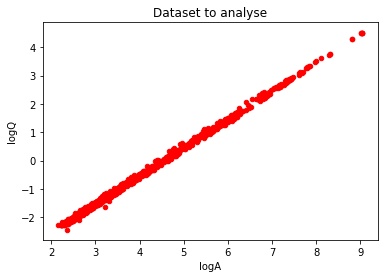

,l,A,Q,n,logQ,logA
0,1.72,13.9,0.121,1,-2.111965,2.631889
1,3.38,24.7,0.196,1,-1.629641,3.206803
2,1.94,13.7,0.160,1,-1.832581,2.617396
3,1.12,10.3,0.116,1,-2.154165,2.332144
4,5.95,20.7,0.242,1,-1.418818,3.030134


In [4]:
# define the dataset
df = pd.DataFrame(table)
df = df.head(1000) #subsetting data to first 1000 data points
df['logQ'] = np.log(df['Q'])
df['logA']=np.log(df['A'])
# plot the dataset
df.plot(x="logA", y="logQ", kind="scatter", color="r", title="Dataset to analyse")
plt.show()
df.head()

In [5]:
# Linear Regression with Stan
stan_model = ps.StanModel(file="LRmodel.txt")

data_dict = {"logQ": df["logQ"], "logA": df["logA"], "N": len(df)}

stan_fit = stan_model.sampling(data=data_dict)

# # extract the samples
stan_results = pd.DataFrame(stan_fit.extract())
print(stan_results.describe())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cfb426b130992ed055ed8f689117c885 NOW.


            a_zero        a_one        sigma         lp__
count  4000.000000  4000.000000  4000.000000  4000.000000
mean     -4.524666     0.998159     0.058159  2341.930474
std       0.005394     0.001240     0.001315     1.263496
min      -4.543157     0.993951     0.054053  2330.169123
25%      -4.528261     0.997311     0.057264  2341.365672
50%      -4.524678     0.998153     0.058148  2342.268867
75%      -4.521087     0.998994     0.058971  2342.844908
max      -4.505884     1.002303     0.063682  2343.456733


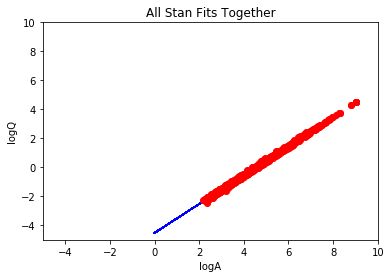

In [6]:
# here is one way to visualise the stan result, including uncertainty
# this does not include any filtering to eg 95%, it simply shows all inferences
for row in range(0, len(stan_results)):
    fit_line = np.poly1d([stan_results["a_one"][row], stan_results["a_zero"][row]])
    x = np.arange(6)
    y = fit_line(x)
    plt.plot(x, y, "b-", alpha=0.025, zorder=1)
plt.scatter(df["logA"], df["logQ"], c="r", zorder=2)
plt.title("All Stan Fits Together")
plt.ylim([-5, 10])
plt.ylabel("logQ")
plt.xlim([-5, 10])
plt.xlabel("logA")
plt.show()